Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Implementação Concisa para Várias GPUs
:label:`sec_multi_gpu_concise`

Implementar o paralelismo do zero para cada novo modelo não é divertido. Além disso, há um benefício significativo na otimização de ferramentas de sincronização para alto desempenho. A seguir, mostraremos como fazer isso usando o Gluon. A matemática e os algoritmos são os mesmos que em :numref:sec_multi_gpu. Como antes, começamos importando os módulos necessários (sem surpresa, você precisará de pelo menos duas GPUs para rodar este notebook).


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Uma Rede de Exemplo

Vamos usar uma rede um pouco mais significativa do que a LeNet da seção anterior, que ainda é suficientemente fácil e rápida de treinar. Escolhemos uma variante do ResNet-18 :cite:`He.Zhang.Ren.ea.2016`.  Como as imagens de entrada são pequenas, nós as modificamos ligeiramente. Em particular, a diferença para :numref:`sec_resnet` é que usamos um kernel de convolução menor, stride e preenchimento no início. Além disso, removemos a camada de *pooling* máximo.


In [2]:
#@save
def resnet18(num_classes, in_channels=1):
    """A slightly modified ResNet-18 model."""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the maximum pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

## Inicialização de Parâmetros e Logística

O método `initialize` nos permite definir padrões iniciais para parâmetros em um dispositivo de nossa escolha. Para uma atualização, consulte :numref:`sec_numerical_stability`. O que é particularmente conveniente é que também nos permite inicializar a rede em *vários* dispositivos simultaneamente. Vamos tentar como isso funciona na prática.


In [3]:
net = resnet18(10)
# get a list of GPUs
devices = d2l.try_all_gpus()
# we'll initialize the network inside the training loop

Usando a função `split_and_load` introduzida na seção anterior, podemos dividir um minibatch de dados e copiar porções para a lista de dispositivos fornecida pela variável de contexto. O objeto de rede *automaticamente* usa a GPU apropriada para calcular o valor da propagação direta. Como antes, geramos 4 observações e as dividimos nas GPUs.


Depois que os dados passam pela rede, os parâmetros correspondentes são inicializados *no dispositivo pelo qual os dados passaram*. Isso significa que a inicialização ocorre por dispositivo. Como escolhemos a GPU 0 e a GPU 1 para inicialização, a rede é inicializada apenas lá, e não na CPU. Na verdade, os parâmetros nem existem no dispositivo. Podemos verificar isso imprimindo os parâmetros e observando quaisquer erros que possam surgir.


Por último, vamos substituir o código para avaliar a precisão por um que funcione em paralelo em vários dispositivos. Isso serve como uma substituição da função `evaluate_accuracy_gpu` de :numref:`sec_lenet`.  A principal diferença é que dividimos um lote antes de chamar a rede. Tudo o mais é essencialmente idêntico.


## Treinamento


Como antes, o código de treinamento precisa realizar uma série de funções básicas para paralelismo eficiente:

* Os parâmetros de rede precisam ser inicializados em todos os dispositivos.
* Durante a iteração no conjunto de dados, os minibatches devem ser divididos em todos os dispositivos.
* Calculamos a perda e seu gradiente em paralelo entre os dispositivos.
* As perdas são agregadas (pelo método `trainer`) e os parâmetros são atualizados de acordo.

No final, calculamos a precisão (novamente em paralelo) para relatar o valor final da rede. A rotina de treinamento é bastante semelhante às implementações nos capítulos anteriores, exceto que precisamos dividir e agregar dados.


In [4]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # Set model on multiple gpus
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

## Experimentos

Vamos ver como isso funciona na prática. Como aquecimento, treinamos a rede em uma única GPU.


test acc: 0.89, 14.2 sec/epoch on [device(type='cuda', index=0)]


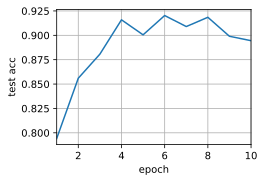

In [5]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

Em seguida, usamos 2 GPUs para treinamento. Comparado ao LeNet, o modelo do ResNet-18 é consideravelmente mais complexo. É aqui que a paralelização mostra sua vantagem. O tempo de cálculo é significativamente maior do que o tempo de sincronização de parâmetros. Isso melhora a escalabilidade, pois a sobrecarga para paralelização é menos relevante.


test acc: 0.81, 9.3 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


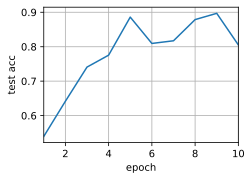

In [6]:
train(net, num_gpus=2, batch_size=512, lr=0.2)

## Resumo

* Gluon fornece primitivas para inicialização de modelo em vários dispositivos, fornecendo uma lista de contexto.
* Os dados são avaliados automaticamente nos dispositivos onde os dados podem ser encontrados.
* Tome cuidado ao inicializar as redes em cada dispositivo antes de tentar acessar os parâmetros naquele dispositivo. Caso contrário, você encontrará um erro.
* Os algoritmos de otimização agregam-se automaticamente em várias GPUs.

## Exercícios

1. Esta seção usa o ResNet-18. Experimente diferentes épocas, tamanhos de lote e taxas de aprendizagem. Use mais GPUs para computação. O que acontece se você tentar isso em uma instância p2.16xlarge com 16 GPUs?
1. Às vezes, dispositivos diferentes fornecem poder de computação diferente. Poderíamos usar as GPUs e a CPU ao mesmo tempo. Como devemos dividir o trabalho? Vale a pena o esforço? Por quê? Por que não?
1. O que acontece se eliminarmos `npx.waitall()`? Como você modificaria o treinamento de forma que houvesse uma sobreposição de até duas etapas para o paralelismo?


[Discussions](https://discuss.d2l.ai/t/1403)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTE4MTE5ODkyMDQsMTE4MTI5ODY2MF19
-->
